In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt

# Slef imports
from eclipses import *
from plotting import *
from cpop import *

In [4]:
# Getting the Curve
eclipse = get_eclipses("kplr006545018.fits", "../data/combined/")
plt.figure(figsize = (20,8))
# plt.scatter(eclipse["time"],getOC(eclipse, "Yuan Xi"))
plt.scatter(eclipse["time"], getOC(eclipse))

NameError: name 'eclipses' is not defined

<Figure size 2000x800 with 0 Axes>

<AxesSubplot:xlabel='time', ylabel='delta'>

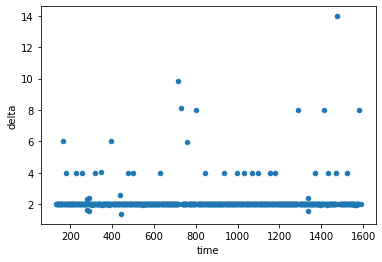

: 

In [ ]:
eclipse.plot.scatter(y='delta', x='time')